# Week 4 - Programming question 1
>Consider again the data set in *week 4 assignment*, and recall that we have transformed the data into classification and regression sets.  

## Classfication using GDA
Your task is to use Gaussian Discriminant Analysis (GDA) to build a classification model. To complete this assignment, make sure you:
* a) Write your own code to implement the GDA algorithm. (Do not use built-in classification functions.)
* b) Clearly explain how the GDA model works and why it can be used for classification, in particular this data set.
* c) Train your model on the given dataset and report its accuracy. Be explicit about how you measure performance (e.g., accuracy on a test set, cross-validation, etc.).
* d) Plot the decision boundary of your model and include the visualization in your report.

In [1]:
import re, math, numpy as np
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
df_cls = pd.read_csv("classification_dataset.csv")

In [2]:
def infer_columns(df: pd.DataFrame, y_hint=None):
    cols = df.columns.str.lower()
    # label / target
    if y_hint and y_hint in df.columns:
        ycol = y_hint
    else:
        label_patterns = [r'^(label|y|target|class|valid|is_valid)$']
        ycol = None
        for p in label_patterns:
            m = [c for c in df.columns if re.match(p, c.lower())]
            if m: 
                ycol = m[0]; break

    # latitude / longitude
    lat_candidates = [c for c in df.columns if re.search(r'lat', c.lower())]
    lon_candidates = [c for c in df.columns if re.search(r'lon|lng|long', c.lower())]

    xcols = [lat_candidates[0], lon_candidates[0]]
    return xcols, ycol

def train_test_split_xy(X, y, test_size=0.2, seed=42):
    rng = np.random.default_rng(seed)
    n = len(X)
    idx = np.arange(n)
    rng.shuffle(idx)
    n_te = int(round(n*test_size))
    te_idx, tr_idx = idx[:n_te], idx[n_te:]
    return X[tr_idx], X[te_idx], y[tr_idx], y[te_idx]


### GDA

In [3]:
class GDA:
    def __init__(self, reg=1e-6):
        self.reg = reg
        self.mu0 = None
        self.mu1 = None
        self.Sigma = None
        self.phi = None
        self.invSigma = None
        self.const_ = None 

    def fit(self, X: np.ndarray, y: np.ndarray):
        # X: (n, d)   y ∈ {0,1}
        X0 = X[y==0]; X1 = X[y==1]
        self.mu0 = X0.mean(axis=0)
        self.mu1 = X1.mean(axis=0)
        # pooled covariance
        S0 = np.cov(X0, rowvar=False, bias=False)
        S1 = np.cov(X1, rowvar=False, bias=False)
        n0, n1 = len(X0), len(X1)
        self.Sigma = ((n0-1)*S0 + (n1-1)*S1) / (n0+n1-2)
        # regularize
        self.Sigma = self.Sigma + self.reg*np.eye(X.shape[1])
        self.invSigma = np.linalg.inv(self.Sigma)

        self.phi = X1.shape[0] / X.shape[0]

        
        w = self.invSigma @ (self.mu1 - self.mu0)
        b = (-0.5*self.mu1.T @ self.invSigma @ self.mu1
             +0.5*self.mu0.T @ self.invSigma @ self.mu0
             + np.log(self.phi/(1-self.phi)))
        self.const_ = (w, b)
        return self

    def decision_function(self, X):
        # return log-odds: log P(y=1|x) - log P(y=0|x)
        w, b = self.const_
        return X @ w + b

    def predict_proba(self, X):
        s = self.decision_function(X)
        # sigmoid
        p1 = 1.0 / (1.0 + np.exp(-s))
        return np.vstack([1-p1, p1]).T

    def predict(self, X):
        return (self.predict_proba(X)[:,1] >= 0.5).astype(int)



[GDA] test accuracy = 0.5343283582089552
[GDA] confusion matrix:
 [[1074    6]
 [ 930    0]]


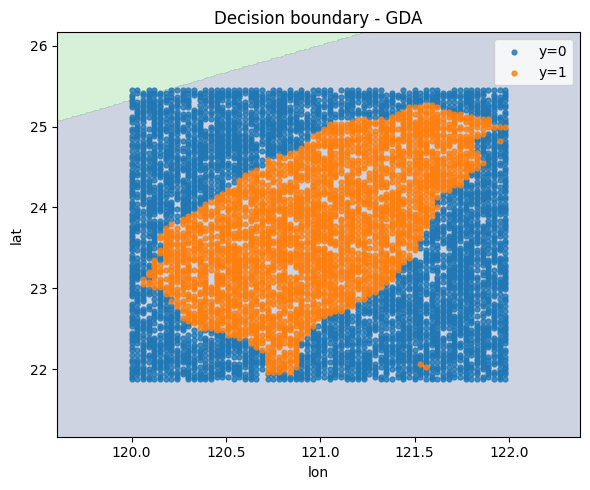

In [4]:
#===============================================
# ====== Accuracy & plt======
def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true==1)&(y_pred==1))
    tn = np.sum((y_true==0)&(y_pred==0))
    fp = np.sum((y_true==0)&(y_pred==1))
    fn = np.sum((y_true==1)&(y_pred==0))
    return np.array([[tn, fp],
                     [fn, tp]])

def plot_decision_boundary(model, X, y, xcols, padding=0.2, grid=300):
    
    X_swapped = X[:, [1, 0]]  # 原 [lat, lon] → 變 [lon, lat]

    x_min, x_max = X_swapped[:,0].min(), X_swapped[:,0].max()
    y_min, y_max = X_swapped[:,1].min(), X_swapped[:,1].max()
    dx, dy = x_max - x_min, y_max - y_min
    x_min -= padding*dx; x_max += padding*dx
    y_min -= padding*dy; y_max += padding*dy

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid),
        np.linspace(y_min, y_max, grid)
    )
    
    ZZ = model.predict(np.c_[yy.ravel(), xx.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, ZZ, alpha=0.25, levels=[-0.5,0.5,1.5])
    plt.scatter(X_swapped[y==0,0], X_swapped[y==0,1], s=12, label='y=0', alpha=0.8)
    plt.scatter(X_swapped[y==1,0], X_swapped[y==1,1], s=12, label='y=1', alpha=0.8)
    plt.xlabel(xcols[1])  # longitude
    plt.ylabel(xcols[0])  # latitude
    plt.legend()
    plt.title(f"Decision boundary - {model.__class__.__name__}")
    plt.tight_layout()
    plt.show()

# ====== ======
xcols, ycol = infer_columns(df_cls, y_hint=None)
X = df_cls[xcols].to_numpy(dtype=float)
y = df_cls[ycol].to_numpy(dtype=int)

X_tr, X_te, y_tr, y_te = train_test_split_xy(X, y, test_size=0.25, seed=7)

gda = GDA(reg=1e-6).fit(X_tr, y_tr)
pred_te = gda.predict(X_te)
print("[GDA] test accuracy =", accuracy(y_te, pred_te))
print("[GDA] confusion matrix:\n", confusion_matrix(y_te, pred_te))
plot_decision_boundary(gda, X_tr, y_tr, xcols)



## Cross validation

In [5]:
from sklearn.model_selection import KFold

def cross_val_accuracy(model_class, X, y, k=5, **kwargs):
    """
    Cross-validation for GDA/QDA models (manual implementation).
    model_class: class (e.g., GDA or QDA)
    kwargs: parameters passed to the model
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accs = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = model_class(**kwargs).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = (y_pred == y_test).mean()
        accs.append(acc)
        print(f"[Fold {fold+1}] accuracy = {acc:.4f}")

    mean_acc = np.mean(accs)
    print(f"\n[{model_class.__name__}] {k}-Fold CV mean accuracy = {mean_acc:.4f}")
    return mean_acc


In [6]:
# 25-fold cross validation
cv_acc = cross_val_accuracy(GDA, X, y, k=5, reg=1e-6)


[Fold 1] accuracy = 0.5379
[Fold 2] accuracy = 0.5236
[Fold 3] accuracy = 0.5361
[Fold 4] accuracy = 0.5553
[Fold 5] accuracy = 0.5218

[GDA] 5-Fold CV mean accuracy = 0.5350


---

## QDA

In [7]:
# QDA
class QDA:
    def __init__(self, reg=1e-6):
        self.reg = reg
        self.mu = {}
        self.Sigma = {}
        self.invSigma = {}
        self.logdet = {}
        self.pi = {}

    def fit(self, X, y):
        classes = [0,1]
        n = len(X)
        for k in classes:
            Xk = X[y==k]
            if len(Xk)==0: 
                raise ValueError(f"類別 {k} 沒資料。")
            self.mu[k] = Xk.mean(axis=0)
            S = np.cov(Xk, rowvar=False, bias=False) + self.reg*np.eye(X.shape[1])
            self.Sigma[k] = S
            self.invSigma[k] = np.linalg.inv(S)
            self.logdet[k] = np.log(np.linalg.det(S))
            self.pi[k] = len(Xk)/n
        return self

    def _log_gauss(self, X, k):
        d = X.shape[1]
        xc = X - self.mu[k]
        Q = np.einsum('ij,jk,ik->i', xc, self.invSigma[k], xc)  # Mahalanobis
        return -0.5*(Q + self.logdet[k] + d*np.log(2*np.pi))

    def predict_proba(self, X):
        logp0 = self._log_gauss(X, 0) + np.log(self.pi[0])
        logp1 = self._log_gauss(X, 1) + np.log(self.pi[1])
        # normalize via log-sum-exp
        m = np.maximum(logp0, logp1)
        p0 = np.exp(logp0 - m); p1 = np.exp(logp1 - m)
        Z = p0 + p1
        return np.vstack([p0/Z, p1/Z]).T

    def predict(self, X):
        return (self.predict_proba(X)[:,1] >= 0.5).astype(int)


[QDA] test accuracy = 0.8313432835820895
[QDA] confusion matrix:
 [[958 122]
 [217 713]]


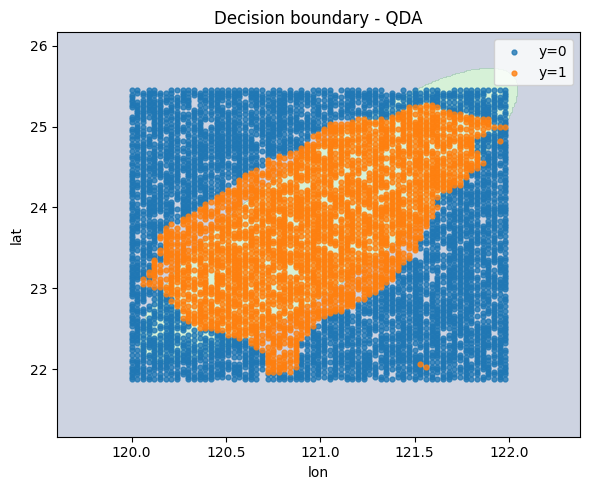

In [8]:
# (B) （可選）QDA：各類別協方差
qda = QDA(reg=1e-6).fit(X_tr, y_tr)
pred_te_q = qda.predict(X_te)
print("[QDA] test accuracy =", accuracy(y_te, pred_te_q))
print("[QDA] confusion matrix:\n", confusion_matrix(y_te, pred_te_q))
plot_decision_boundary(qda, X_tr, y_tr, xcols)

※為了確認程式能完整執行，本檔案在最終提交前重新執行（重跑）一次。由於模型訓練過程包含隨機初始化與資料抽樣，最終的訓練與測試結果可能與先前版本略有不同，但不影響整體結論與分析方向。